# Exponential smoothing sampling

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import seaborn.objects as so

pd.set_option("mode.copy_on_write", True)

In [2]:
col_val = "val"
sample_size = 10000

## Plotting helper functions

In [3]:
def plot_dists(df_orig, df_new):
    df_disp = pd.concat([
        df_orig.assign(df_name="original"),
        df_new.assign(df_name="new")
    ])
    return (
        so.Plot(df_disp, x=col_val, color="df_name")
        .add(so.Bars(), so.Hist())
    )

## Prepare data

In [4]:
df_orig = pd.DataFrame({
    col_val: np.floor(np.random.exponential(0.3, size=sample_size) * 1000)
}).astype({col_val: int})
df_orig.head(5)

,val
0,266
1,388
2,44
3,110
4,765


## With Pandas

In [5]:
def exponential_smoothing_sampling(df):
    alpha = 0.3
    col_count = "count"
    dict_weight = dict(
        df[col_val]
        .value_counts()
        .reset_index()
        .rename(columns={0: col_count})
        .assign(weight=lambda df_: df_[col_count] ** alpha / df_[col_count])
        [[col_val, "weight"]]
        .values
    )

    return (df
        .assign(weight=df[col_val].apply(lambda x: dict_weight[x]))
        .sample(len(df), replace=True, weights="weight")
    )

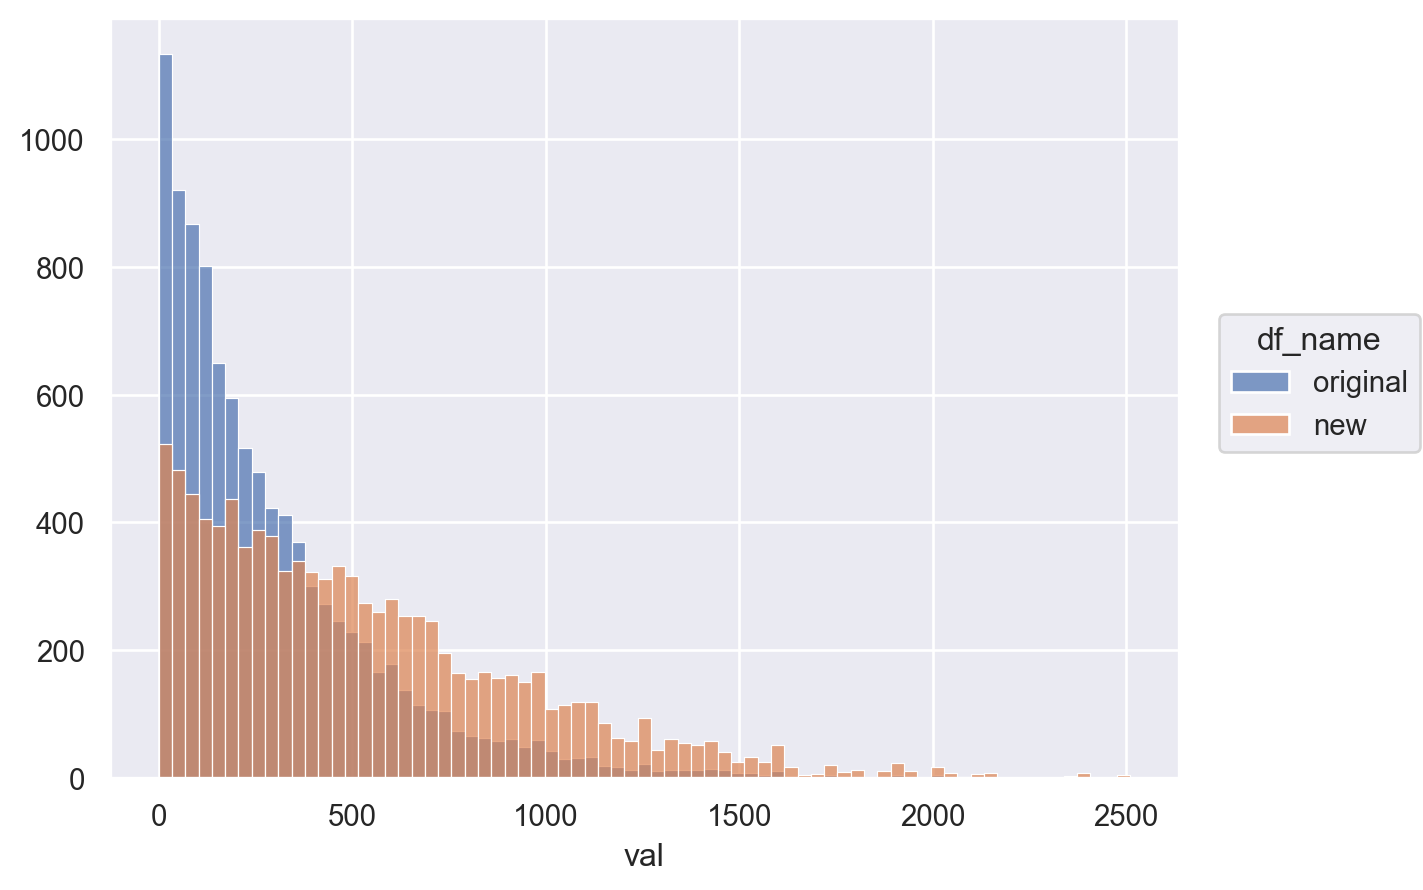

In [6]:
plot_dists(df_orig, df_orig.pipe(exponential_smoothing_sampling))

## With Polars

https://github.com/pola-rs/polars/issues/2661
https://github.com/pola-rs/polars/pull/11943

In [7]:
def add_weights(df):
    alpha = 0.3
    col_count = "count"
    dict_weight = dict(
        df[col_val]
        .value_counts()
        .reset_index()
        .rename(columns={0: col_count})
        .assign(weight=lambda df_: df_[col_count] ** alpha / df_[col_count])
        [[col_val, "weight"]]
        .values
    )

    df_w_weight = df.assign(weight=df[col_val].apply(lambda x: dict_weight[x]))
    total_weights = df_w_weight.agg({"weight": "sum"})

    return df_w_weight.assign(p=df_w_weight["weight"].apply(lambda x: x / total_weights))

In [8]:
df_1 = pl.from_pandas(df_orig.pipe(add_weights))
df_1.head(5)

val,weight,p
i64,f64,f64
266,0.132224,0.000066
388,0.256113,0.000127
44,0.092473,0.000046
110,0.127313,0.000063
765,0.324131,0.000161


In [9]:
df_2 = df_1.with_row_index("row_idx")
df_2.head(5)

row_idx,val,weight,p
u32,i64,f64,f64
0,266,0.132224,0.000066
1,388,0.256113,0.000127
2,44,0.092473,0.000046
3,110,0.127313,0.000063
4,765,0.324131,0.000161


In [10]:
sampled = (df_2
    .group_by(col_val)
    .agg([
        pl.col("row_idx").sample(
            fraction=pl.col("p").first() * sample_size,
            with_replacement=True, seed=1
        )
    ])
    .explode("row_idx")
)
len(sampled)

9301

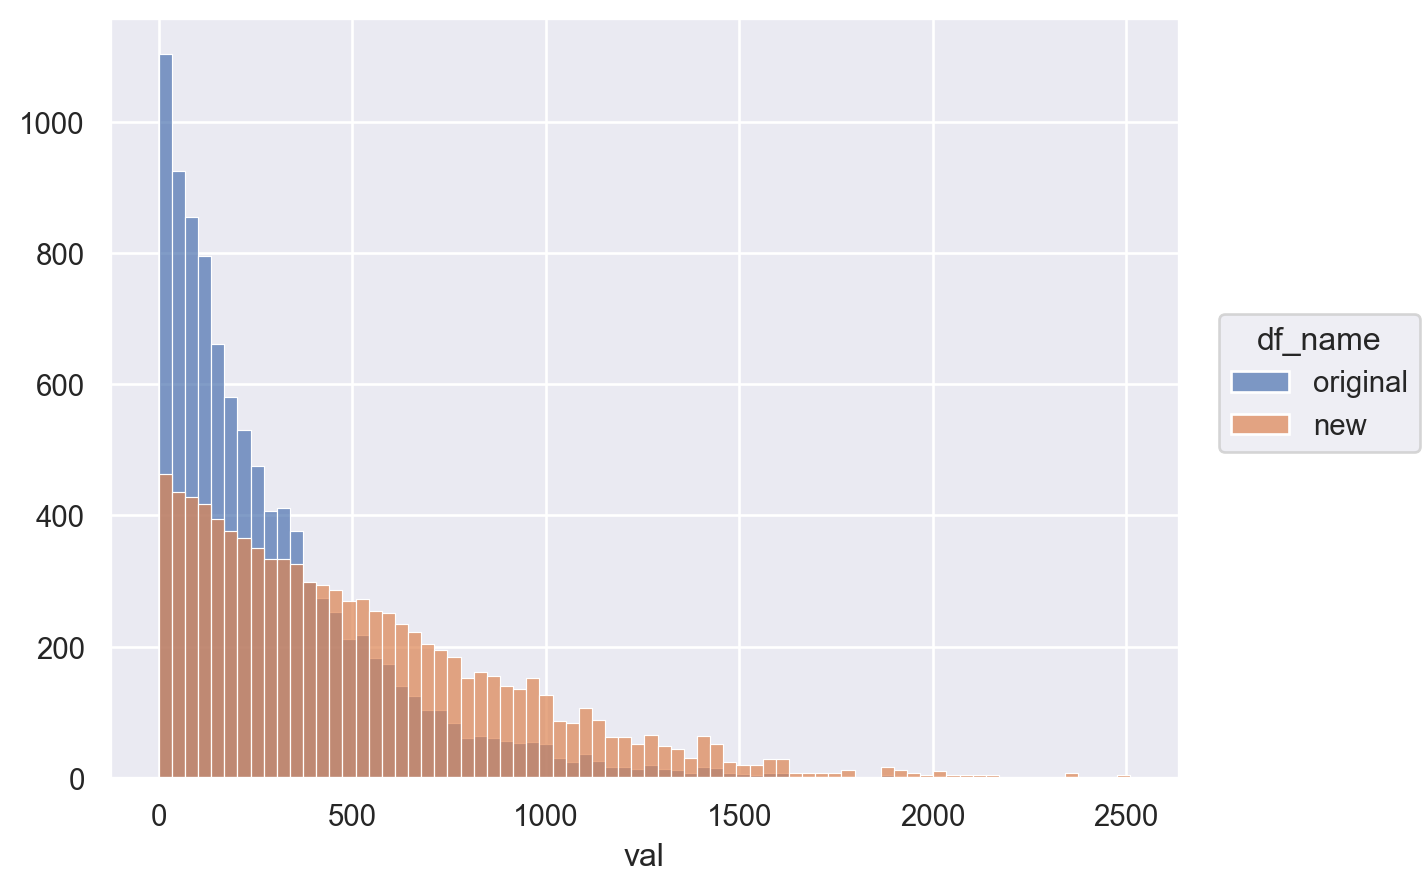

In [11]:
plot_dists(df_orig, sampled.to_pandas())